## Geomapper

#### TJ Slezak - Galvanize Data Science Graduate

#### https://www.github.com/tjslezak/capstone



### Step 0. Getting the data

Locate imagery: https://apps.sentinel-hub.com/eo-browser/?lat=33.4177&lng=-111.5813&zoom=10

In [1]:
from sentinelhub import AwsTile, DataSource

product_ids = set()
product_ids.add(AwsTile(tile_name='12SVC', time='2019-01-23', aws_index='0', data_source=DataSource.SENTINEL2_L2A).get_product_id())
product_ids

{'S2B_MSIL2A_20190123T181639_N0211_R084_T12SVC_20190123T202137'}

In [2]:
from sentinelhub import AwsProductRequest
data_folder = './data'
n, total = 0, len(product_ids)

for product in product_ids:
    product_request = AwsProductRequest(product_id=product, data_folder=data_folder, safe_format=True)
    product_request.save_data()
    pid = product.split('_')[-2][1:]
    n += 1
    print('|' + pid, sep='', end=': {}% | '.format(round(n/total * 100)), flush=True)

|12SVC: 100% | 

In [3]:
import glob
fd = dict()
fd['12SVC'] = glob.glob('./data/**L2A_**.SAFE')
fd

{'12SVC': ['./data/S2B_MSIL2A_20190123T181639_N0211_R084_T12SVC_20190123T202137.SAFE']}

In [4]:
import os
home = './data/'

for tile in fd:
    cmd = 'mkdir -p {}{}'.format(home, tile)
    os.system(cmd)

In [5]:
ls './data/'

12SVC/
S2B_MSIL2A_20190123T181639_N0211_R084_T12SVC_20190123T202137.SAFE/


In [6]:
base_dir = './data/S2B_MSIL2A_20190123T181639_N0211_R084_T12SVC_20190123T202137.SAFE/'
ext_dir = 'GRANULE/L2A_T12SVC_A009834_20190123T182447/IMG_DATA/R10m/'
preview_path = base_dir + ext_dir 

In [7]:
ls './data/S2B_MSIL2A_20190123T181639_N0211_R084_T12SVC_20190123T202137.SAFE/GRANULE/L2A_T12SVC_A009834_20190123T182447/IMG_DATA/R10m/'

T12SVC_20190123T181639_AOT_10m.jp2  T12SVC_20190123T181639_B08_10m.jp2
T12SVC_20190123T181639_B02_10m.jp2  T12SVC_20190123T181639_TCI_10m.jp2
T12SVC_20190123T181639_B03_10m.jp2  T12SVC_20190123T181639_WVP_10m.jp2
T12SVC_20190123T181639_B04_10m.jp2


#### Step 1: Raster (Imagery) Processing 

In [8]:
imgpath = preview_path + 'T12SVC_20190123T181639_TCI_10m.jp2'

import rasterio
import xarray as xr
import hvplot.xarray

In [9]:
img = xr.open_rasterio(imgpath)
img.hvplot(rasterize=True, dynamic=True, width=700, height=700)

:DynamicMap   []
   :RGB   [x,y]   (R,G,B)

In [10]:
p1 = './data/S2B_MSIL2A_20190123T181639_N0211_R084_T12SVC_20190123T202137.SAFE/'
p2 = 'GRANULE/L2A_T12SVC_A009834_20190123T182447/IMG_DATA/R20m/'
pth = p1 + p2
# This code writes out a 3-band geotiff from 3, 1-band geotiffs.
for tile in ['12SVC']:
    
    files = glob.glob('{}*'.format(pth))
    for file in files:
        if 'B02_20m' in file:
            b2path = file
        elif 'B04_20m' in file:
            b4path = file
        elif 'B12_20m' in file:
            b12path = file
            
    # Ingest one band to scrape image metadata
    with rasterio.open(b2path, 'r') as initial:
        meta = initial.meta.copy()
        # Update the image metadata to reflect 3 bands
        meta.update(driver='GTiff', count=3)
    
    # Write out each band to the destination file
    with rasterio.open('./data/{}/{}_stack_geo.tif'.format(tile, tile), 'w', **meta) as dst:
        for n, band in enumerate([b2path, b4path, b12path], start=1):
            with rasterio.open(band) as src:
                dst.write_band(n, src.read(1))

In [11]:
ls './data/12SVC'

12SVC_labels.tif     12SVC_raster.tif     12SVC_stack_geo.tif


In [12]:
rst_path = './data/12SVC/12SVC_stack_geo.tif'

In [13]:
import geotoolkit as geotk

img = xr.open_rasterio(rst_path)
img = geotk.normalize(img)
img.hvplot(rasterize=True, dynamic=True, width=700, height=700)

:DynamicMap   []
   :RGB   [x,y]   (R,G,B)

### Step 3: Vector data

In [14]:
import fiona
import shapely
import geopandas as gpd

In [15]:
azgeo_path = 'https://github.com/azgs/geologic-map-of-arizona/raw/gh-pages/data/MapUnitPolys.geojson'
geology = gpd.read_file(azgeo_path)
geology.head()

mapunitpolys_id mapunit   identityconfidence label symbol  \
0  GMA.MapUnitPolys.297      Qo  Standard Confidence    Qo     22   
1  GMA.MapUnitPolys.276      M_  Standard Confidence    M_     13   
2  GMA.MapUnitPolys.277      P*  Standard Confidence    P*     16   
3  GMA.MapUnitPolys.278      ^m  Standard Confidence    ^m     50   
4  GMA.MapUnitPolys.279      P*  Standard Confidence    P*     16   

                                               notes         datasourceid  \
0  Coarse relict alluvial fan deposits that form ...  GMA.DataSources.121   
1  Brown to dark gray sandstone grades upward int...  GMA.DataSources.121   
2                                                      GMA.DataSources.19   
3  Dark red sandstone and mudstone; includes gyps...  GMA.DataSources.121   
4                                                     GMA.DataSources.121   

                                            geometry  
0  POLYGON ((-113.895423 36.197523, -113.901321 3...  
1  POLYGON ((-112.967515 36.231616, -112.970417 3...  
2  POLYGON ((-112.193484 36.25195, -112.186717 36...  
3  POLYGON ((-113.486314 36.256359, -113.480616 3...  
4  POLYGON ((-112.161519 36.253046, -112.160419 3...

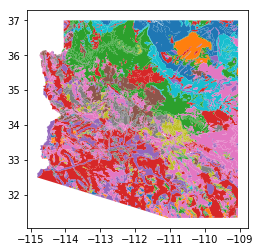

In [16]:
%matplotlib inline
geology.plot(column='mapunit')

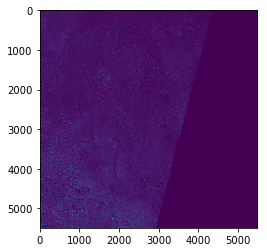

In [17]:
from rasterio.plot import *
show(img[1])

In [18]:
path_to_desc = 'https://raw.githubusercontent.com/azgs/geologic-map-of-arizona/gh-pages/data/DescriptionOfMapUnits.csv'

In [19]:
# Find all vector layers that intersecting with the image, rasterize it.
label_array = geotk.generate_label_array(rst_path, azgeo_path, path_to_desc)
# Format name of file to write
out_fn = geotk.format_label_fn(rst_path)
# Writes rasterized labels numpy array to GeoTiff
geotk.write_label_image(label_array, rst_path, out_fn)

In [20]:
pwd

'/Users/tjs/desertpy/presentations/data-science-monsoon/Slezak-Capstone-Demo'

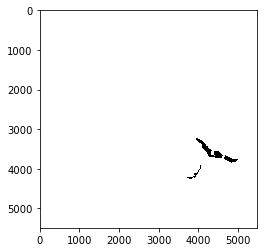

In [21]:
lblpth = './data/12SVC/12SVC_labels.tif'
imgpth = './data/12SVC/12SVC_stack_geo.tif'

srclbl = rasterio.open(lblpth)
msk = srclbl.read_masks()
show(msk) 

In [22]:
geotk.mask_raster(imgpth, lblpth)

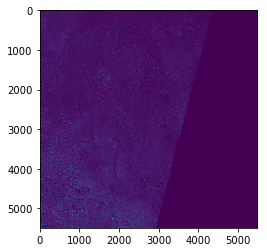

In [23]:
rstpth = imgpth.replace('stack_geo', 'raster' )
show(rasterio.open(rstpth).read(2))

# linkedin.com/in/tslezak